# The TESS full-frame images lightcurve of nova V606 Vul extracted using LightKurve package

This notebook is created to address the referee's comments on the paper "TESS photometry of the nova eruption in V606 Vul: asymmetric photosphere and multiple ejections?" ([arXiv e-print](https://arxiv.org/abs/2311.04903)) submitted to ApJ. While we direct readers to the paper for the final period analysis, this notebook reproduces the main claim: the presence of a ~0.1277 day period in the nova light curve near its peak brightness, using only the standard TESS data analysis package [LightKurve](https://github.com/lightkurve/lightkurve).

The eruption of V606 Vul was happening during the TESS Sector 41 and we start with the analysis of the eruption lightcurve. The same analysis is then applied to the two pre-eruption and three post-eruption TESS sectors covering the nova position to reveal that these sectors contain no useful data as the nova is too faint for TESS outside Sector 41.

We then produce Sector 41 lightcurves for two check stars 4 and 10 arcminutes from the nova to make sure the 0.1277 day modulation found in the nova lightcurve is not present in other sources.

For each source we also extract and analyze the associated off-source (background-only) lightcurve. The Sector 41 background lightcurves are affected by a 0.333 day modulation found consistently for the source and check stars. However, this modulaiton is not detectable in the background-subtracted lightcurves of the nova and check stars.

/home/kirill/.conda/envs/lk/lib/python3.10/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /home/kirill/.lightkurve/cache. Please move all the files in the legacy directory /home/kirill/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


Searching for TESS data for V606 Vul
Found 6 TESS sectors with data
SearchResult containing 6 data products.

 #     mission     year  author exptime         target_name         distance
                                   s                                 arcsec 
--- -------------- ---- ------- ------- --------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:21:07.7044 +29:14:09.091      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:21:07.7044 +29:14:09.091      0.0
  2 TESS Sector 41 2021 TESScut     475 20:21:07.7044 +29:14:09.091      0.0
  3 TESS Sector 55 2022 TESScut     475 20:21:07.7044 +29:14:09.091      0.0
  4 TESS Sector 81 2024 TESScut     158 20:21:07.7044 +29:14:09.091      0.0
  5 TESS Sector 82 2024 TESScut     158 20:21:07.7044 +29:14:09.091      0.0


<Figure size 800x600 with 0 Axes>

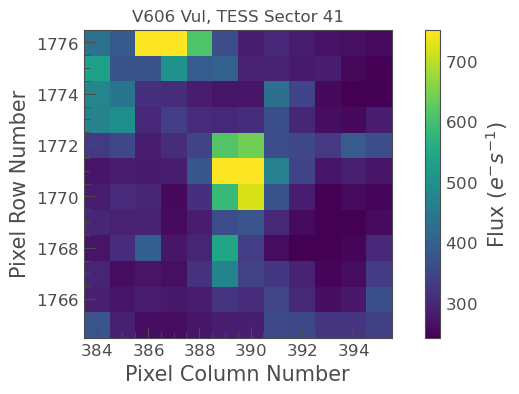

Starting per-pixel periodogram analysis...
Cutout dimensions: 12 x 12 pixels
Processing 144 pixels...


  0%|          | 0/12 [00:00<?, ?it/s]

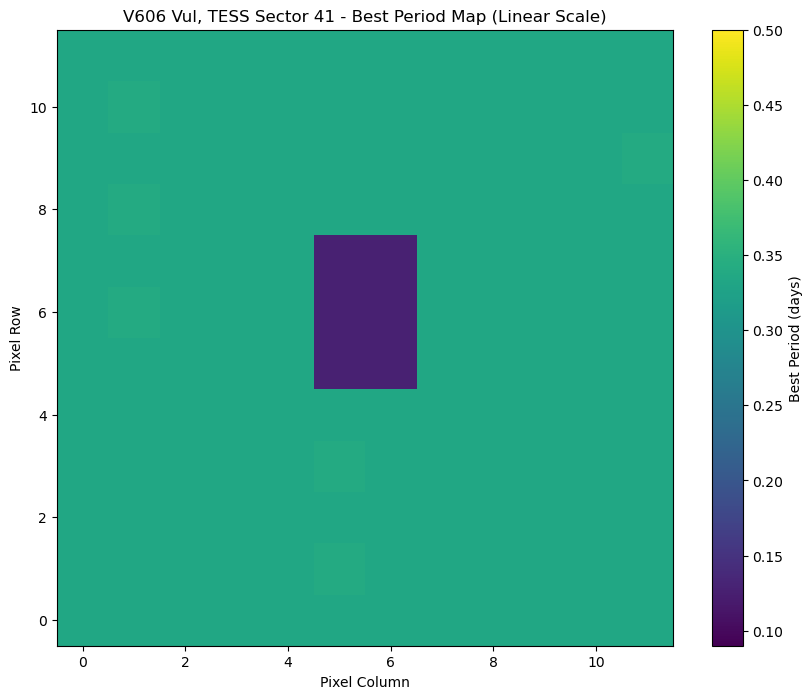

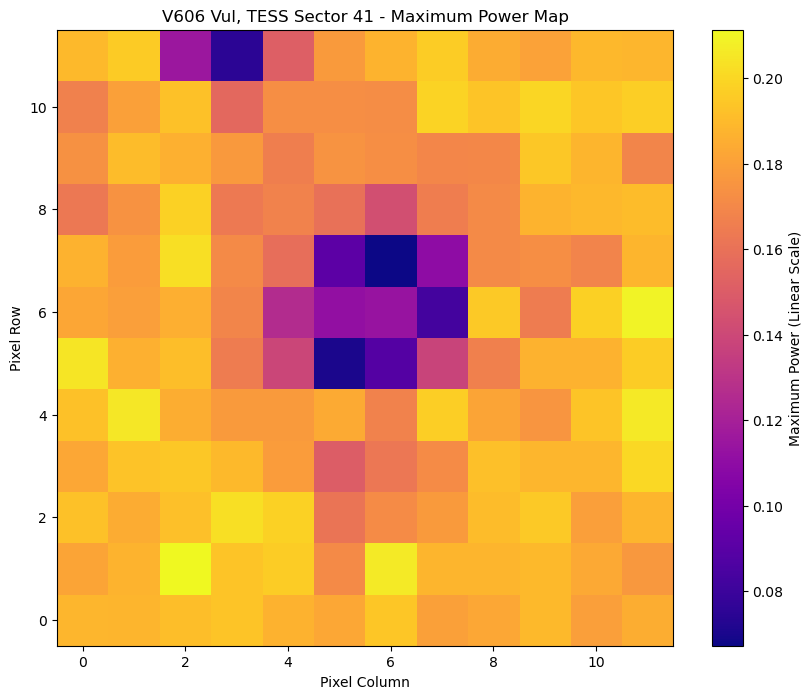

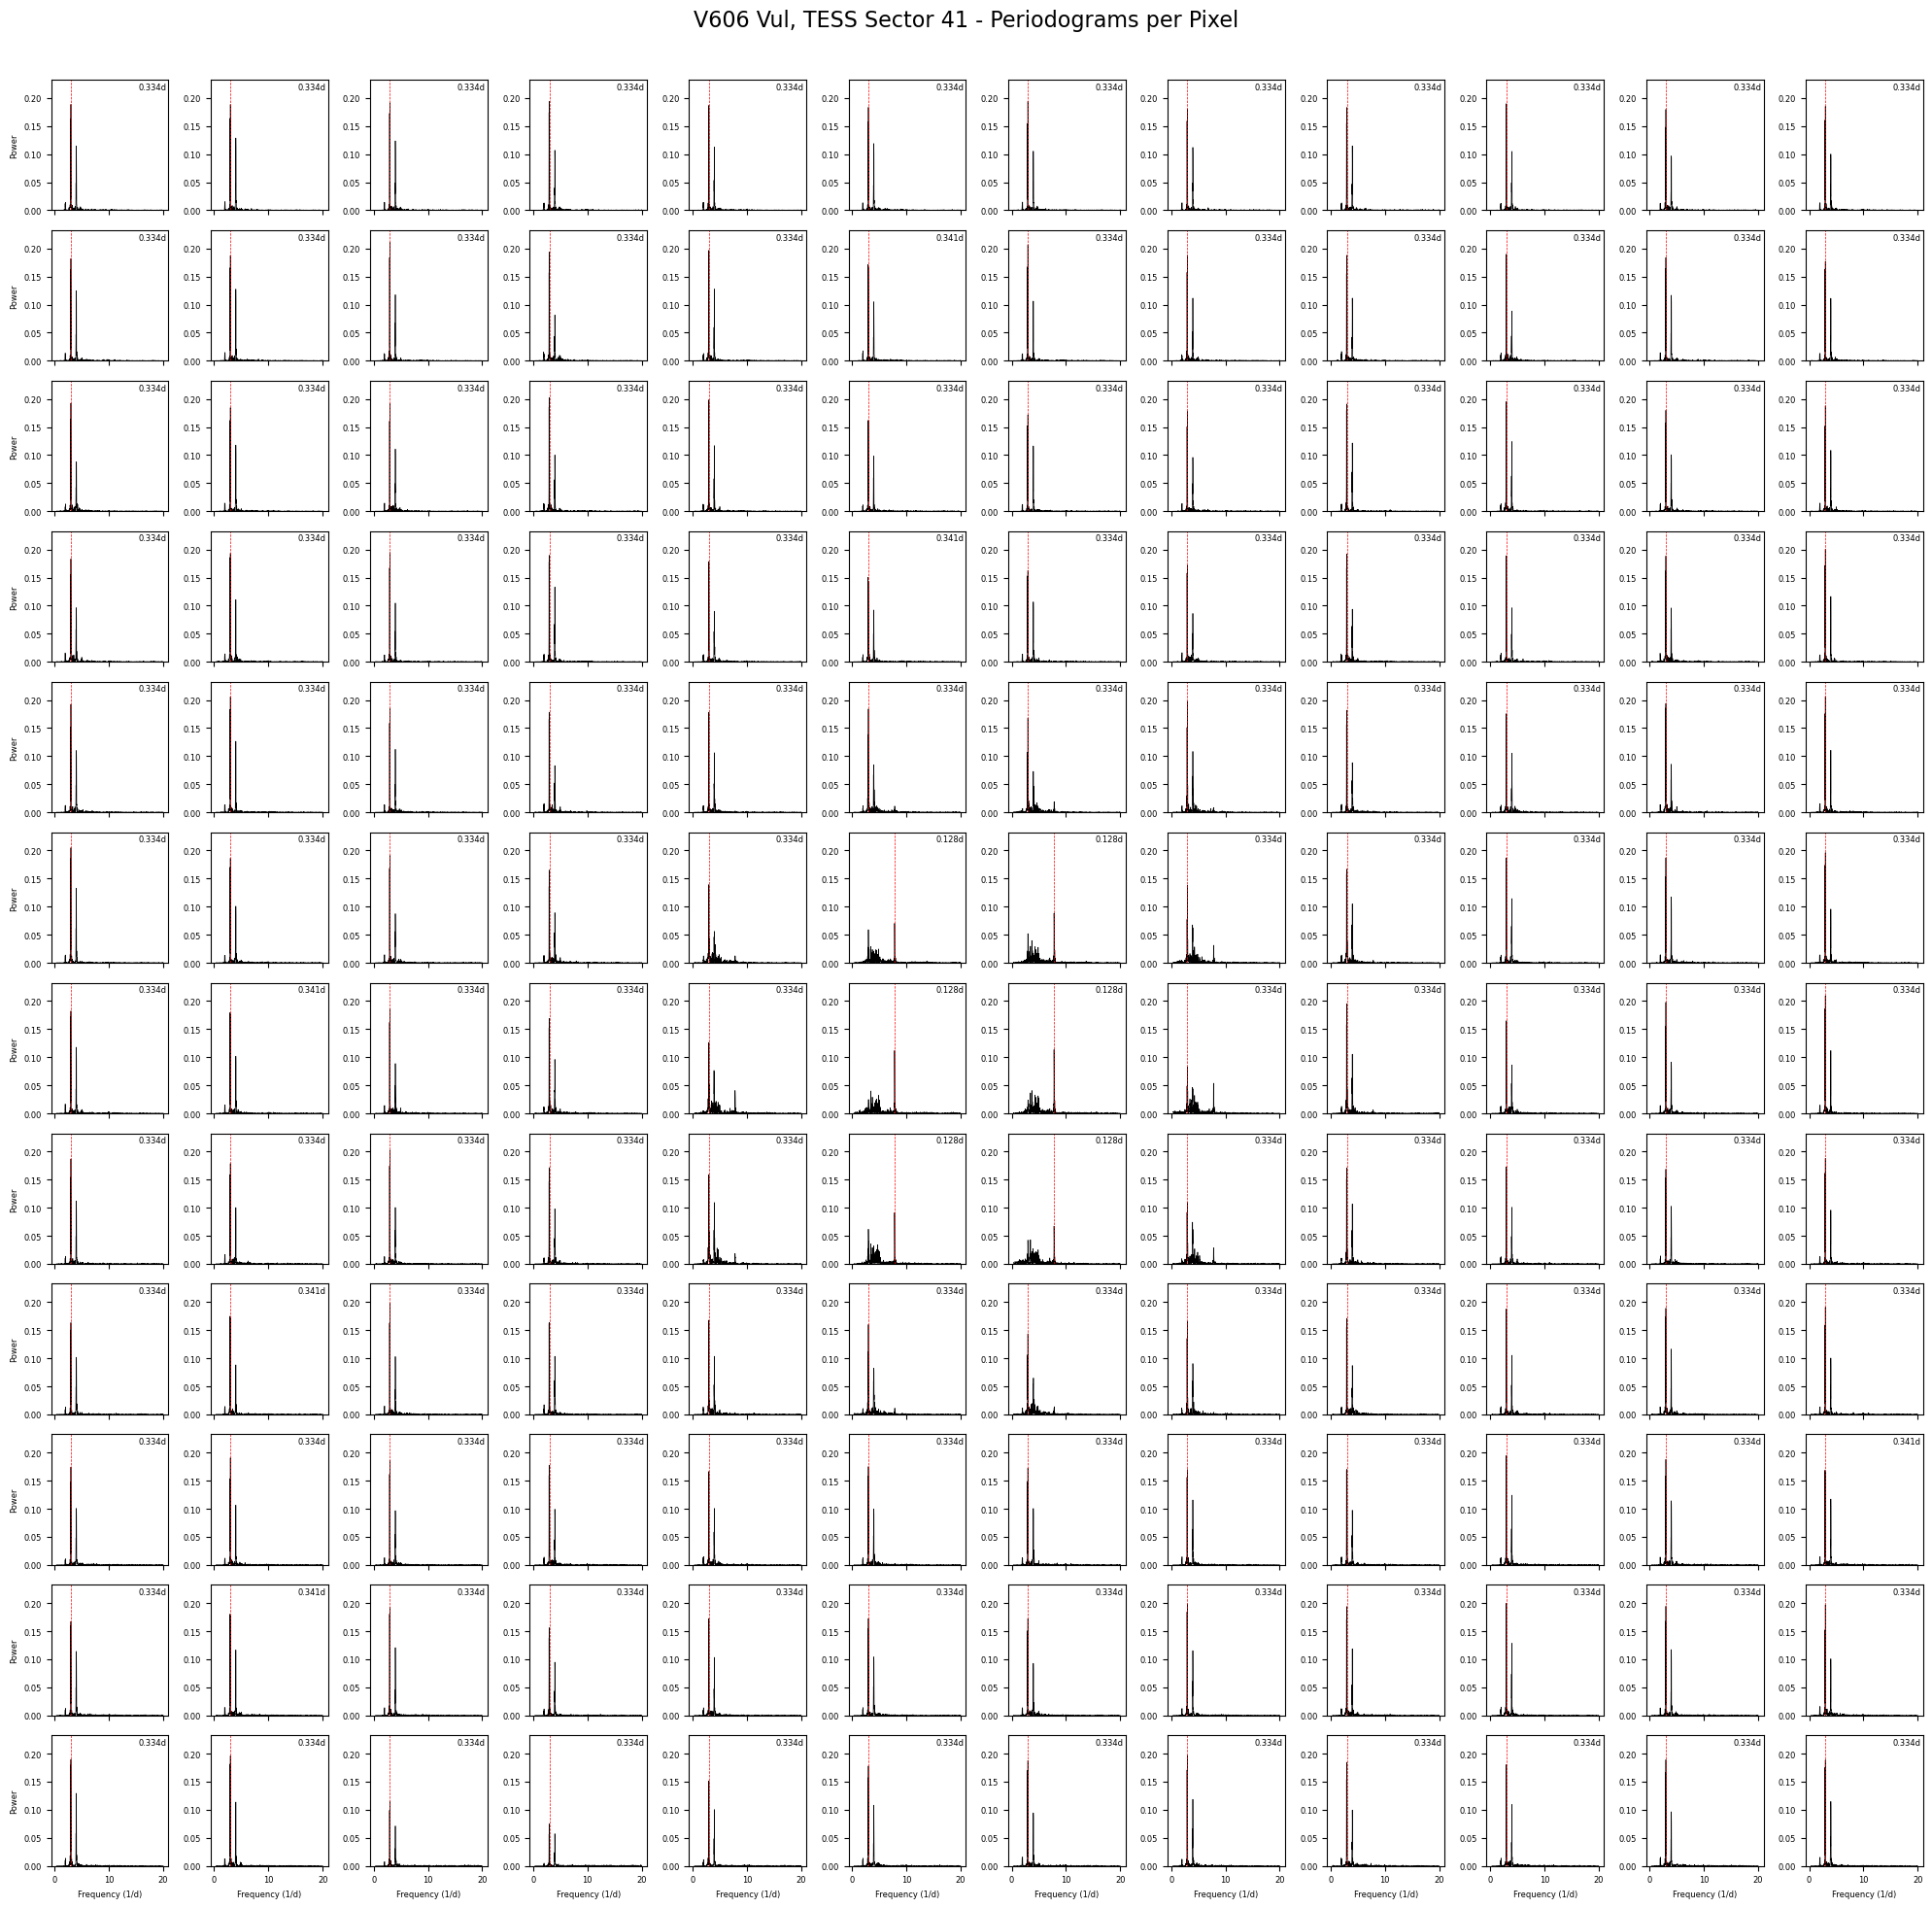

Analysis complete!
Period map shape: (12, 12)
Periodogram array shape: (12, 12, 1000, 2)
Number of pixels with valid periods: 144
Mean period: 0.3260 days
Median period: 0.3343 days
Min period: 0.1280 days
Max period: 0.3411 days


In [1]:
# Per-Pixel Periodogram Analysis for TESS Data - V606 Vul
# Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
from astropy.timeseries import LombScargle
%matplotlib inline

def analyze_tess_cutout_per_pixel(tpf_cutout, target_source_name, period_range=(0.05, 3.0), 
                                  notebook_name="v606_vul_per_pixel_analysis"):
    """
    Process TESS lightcurve data from a TPF cutout and perform period search on each pixel individually.
    
    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    period_range: tuple
        The range of periods (in days) to search for.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    
    Returns:
    period_map: 2D numpy array
        Array containing the best period for each pixel.
    power_map: 2D numpy array
        Array containing the maximum power for each pixel.
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get the dimensions of the cutout
    rows, cols = tpf_cutout[0].shape[1:]
    print(f"Cutout dimensions: {rows} x {cols} pixels")
    
    # Create arrays to store results
    period_map = np.zeros((rows, cols))
    power_map = np.zeros((rows, cols))
    
    # Define the frequency grid for all periodograms
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period
    
    # We'll define a common frequency grid for all pixels
    frequency_grid = np.linspace(min_frequency, max_frequency, 1000)
    
    # Create a 4D array to store periodogram data for each pixel
    # (rows, cols, frequencies, [frequency, power])
    periodogram_array = np.zeros((rows, cols, len(frequency_grid), 2))
    
    # Store the frequency grid in all pixels
    for i in range(rows):
        for j in range(cols):
            periodogram_array[i, j, :, 0] = frequency_grid
    
    # Process each pixel
    print(f"Processing {rows*cols} pixels...")
    for i in tqdm(range(rows)):
        for j in range(cols):
            # Create a mask for this specific pixel
            pixel_mask = np.zeros((rows, cols), dtype=bool)
            pixel_mask[i, j] = True
            
            try:
                # Extract the lightcurve for this pixel
                pixel_lc = tpf_cutout.to_lightcurve(aperture_mask=pixel_mask)
                
                # Skip pixels with no data or all zeros/NaNs
                if len(pixel_lc.flux) == 0 or np.all(pixel_lc.flux == 0) or np.all(np.isnan(pixel_lc.flux)):
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Remove NaN values
                pixel_lc = pixel_lc.remove_nans()
                
                # Skip if too few points remain
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Process the lightcurve: remove outliers, detrend, etc.
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Detrend the lightcurve
                pixel_lc = pixel_lc.flatten(window_length=101, polyorder=5)
                
                # Remove outliers again
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed after detrending
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Calculate the periodogram using the pre-defined frequency grid
                ls = LombScargle(pixel_lc.time.value, pixel_lc.flux.value)
                power = ls.power(frequency_grid)
                
                # Store the power values in the periodogram array
                periodogram_array[i, j, :, 1] = power
                
                # Find the best period
                best_idx = np.argmax(power)
                best_frequency = frequency_grid[best_idx]
                best_period = 1.0 / best_frequency
                max_power = power[best_idx]
                
                # Store the results
                period_map[i, j] = best_period
                power_map[i, j] = max_power
                
            except Exception as e:
                print(f"Error processing pixel ({i}, {j}): {str(e)}")
                period_map[i, j] = np.nan
                power_map[i, j] = np.nan
    
    # Create a heatmap of the best periods with custom period range
    plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_period_map = np.ma.masked_invalid(period_map)
    
    # You can change vmin and vmax to customize the period range displayed
    # For example, to focus on periods between 0.1 and 1.0 days:
    #display_min_period = min_period  # Default is min_period from period_range
    #display_max_period = max_period  # Default is max_period from period_range
    display_min_period = 0.5
    display_max_period = 0.1
    
    # You can also choose a different colormap here
    # Some good linear colormaps: 'viridis', 'plasma', 'magma', 'cividis', 'rainbow'
    plt.imshow(masked_period_map, origin='lower', cmap='viridis', 
               vmin=display_min_period, vmax=display_max_period)
    cbar = plt.colorbar(label='Best Period (days)')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Best Period Map (Linear Scale)")
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the period map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_period_map.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_period_map.eps"), 
                format="eps")
    plt.show()
    
    # Create a heatmap of the maximum power - with option for linear scale
    plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_power_map = np.ma.masked_invalid(power_map)
    
    # Option 1: Use log normalization (default)
    use_log_scale = False  # Set to False for linear scale
    
    if use_log_scale:
        # Use log normalization for better visibility of wide dynamic range
        norm = LogNorm(vmin=max(np.nanmin(power_map), 1e-10), 
                      vmax=max(np.nanmax(power_map), 1e-9))
        plt.imshow(masked_power_map, origin='lower', cmap='plasma', norm=norm)
        scale_label = "Maximum Power (Log Scale)"
    else:
        # Use linear scale
        plt.imshow(masked_power_map, origin='lower', cmap='plasma')
        scale_label = "Maximum Power (Linear Scale)"
    
    cbar = plt.colorbar(label=scale_label)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Maximum Power Map")
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the power map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_power_map.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_power_map.eps"), 
                format="eps")
    plt.show()
    
    # Create a grid of periodograms
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True)
    
    # Set a common y-axis limit
    max_power_overall = np.nanmax(periodogram_array[:, :, :, 1])
    
    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            
            # Check if we have valid data for this pixel
            if not np.isnan(period_map[i, j]):
                # Plot the periodogram
                frequencies = periodogram_array[i, j, :, 0]
                powers = periodogram_array[i, j, :, 1]
                
                ax.plot(frequencies, powers, 'k-', linewidth=0.5)
                
                # Highlight the best period
                best_frequency = 1 / period_map[i, j]
                ax.axvline(x=best_frequency, color='r', linestyle='--', linewidth=0.5)
                
                # Set y-axis limit
                ax.set_ylim(0, max_power_overall * 1.1)
                
                # Display the best period in the upper right corner
                ax.text(0.98, 0.98, f"{period_map[i, j]:.3f}d", 
                        horizontalalignment='right', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6)
            
            # Remove ticks for cleaner look
            ax.tick_params(axis='both', which='both', labelsize=6)
            
            # Only add axis labels for the bottom and left edges
            if i == rows-1:
                ax.set_xlabel('Frequency (1/d)', fontsize=6)
            if j == 0:
                ax.set_ylabel('Power', fontsize=6)
    
    plt.suptitle(f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Periodograms per Pixel", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for the suptitle
    
    # Save the periodogram grid
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_periodogram_grid.png"), 
                format="png", dpi=600)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_periodogram_grid.eps"), 
                format="eps")
    plt.show()
    
    # Also save the data as numpy arrays for future use
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_period_map.npy"), 
            period_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_power_map.npy"), 
            power_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_periodogram_array.npy"), 
            periodogram_array)
    
    # Return the maps for further analysis
    return period_map, power_map, periodogram_array

# ---------- RUN THE ANALYSIS ----------

# Set target source name and position, search for TESS data
target_source_name = "V606 Vul"
# Gaia DR3 position of the counterpart
print("Searching for TESS data for", target_source_name)
search_lc = lk.search_tesscut("20:21:07.7044 +29:14:09.091")
print(f"Found {len(search_lc)} TESS sectors with data")
print(search_lc)

# Download and plot the TESS FFI cutout centered on the source
# We're using sector 2 as per the original code
print(f"Downloading cutout for Sector {search_lc[2].mission[0]}")
tpf_cutout = search_lc[2].download(cutout_size=12, quality_bitmask='hard')

# Plot the cutout
plt.figure(figsize=(8, 6))
tpf_cutout.plot()
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
plt.show()

# Run the per-pixel analysis
print("Starting per-pixel periodogram analysis...")
period_map, power_map, periodogram_array = analyze_tess_cutout_per_pixel(
    tpf_cutout, 
    target_source_name,
    period_range=(0.05, 3.0),
    notebook_name="v606_vul_per_pixel_analysis"
)

print("Analysis complete!")
print(f"Period map shape: {period_map.shape}")
print(f"Periodogram array shape: {periodogram_array.shape}")

# Print some statistics about the detected periods
valid_periods = period_map[~np.isnan(period_map)]
if len(valid_periods) > 0:
    print(f"Number of pixels with valid periods: {len(valid_periods)}")
    print(f"Mean period: {np.mean(valid_periods):.4f} days")
    print(f"Median period: {np.median(valid_periods):.4f} days")
    print(f"Min period: {np.min(valid_periods):.4f} days")
    print(f"Max period: {np.max(valid_periods):.4f} days")
else:
    print("No valid periods detected in any pixel.")

#### Background subtraction from each pixel's lightcurve

Searching for TESS data for V606 Vul
Found 6 TESS sectors with data
SearchResult containing 6 data products.

 #     mission     year  author exptime         target_name         distance
                                   s                                 arcsec 
--- -------------- ---- ------- ------- --------------------------- --------
  0 TESS Sector 14 2019 TESScut    1426 20:21:07.7044 +29:14:09.091      0.0
  1 TESS Sector 15 2019 TESScut    1426 20:21:07.7044 +29:14:09.091      0.0
  2 TESS Sector 41 2021 TESScut     475 20:21:07.7044 +29:14:09.091      0.0
  3 TESS Sector 55 2022 TESScut     475 20:21:07.7044 +29:14:09.091      0.0
  4 TESS Sector 81 2024 TESScut     158 20:21:07.7044 +29:14:09.091      0.0
  5 TESS Sector 82 2024 TESScut     158 20:21:07.7044 +29:14:09.091      0.0
Starting per-pixel periodogram analysis with background subtraction...
Cutout dimensions: 12 x 12 pixels
Creating and analyzing background mask...
Background best period: 0.3343 days
Processing 144

  0%|          | 0/12 [00:00<?, ?it/s]

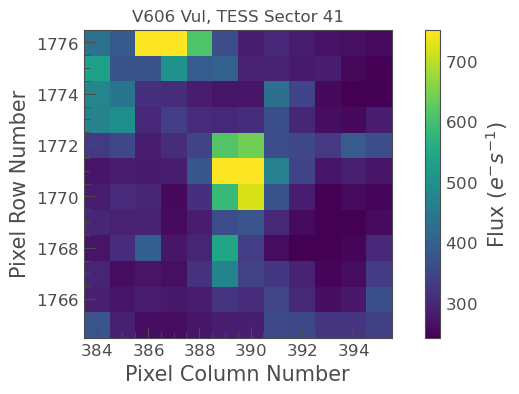

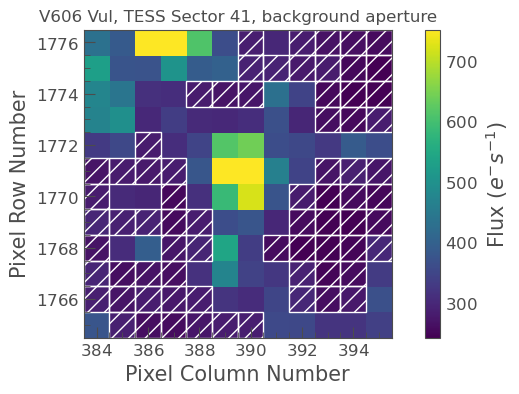

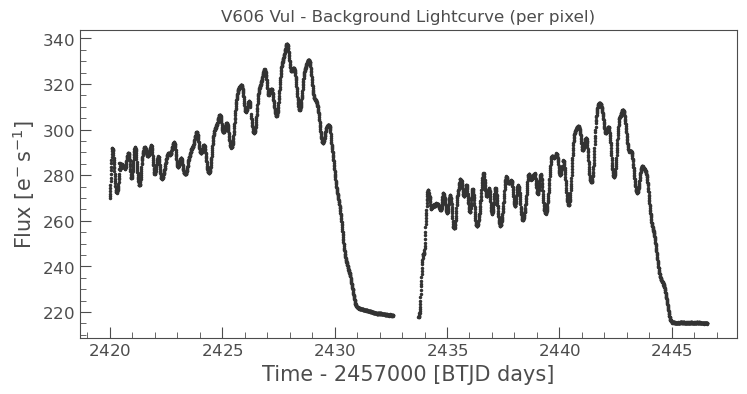

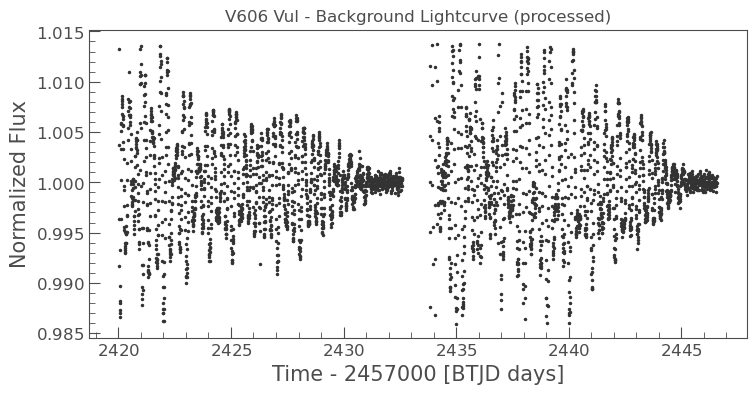

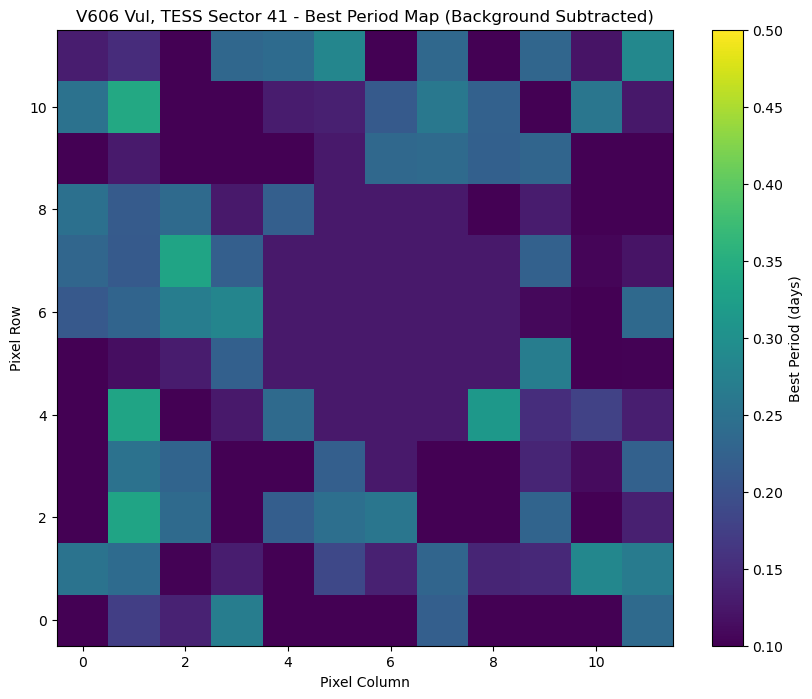

Analysis complete!
Period map shape: (12, 12)
Periodogram array shape: (12, 12, 1000, 2)
Background best period: 0.3343 days
Number of pixels with valid periods: 144
Mean period: 0.1590 days
Median period: 0.1283 days
Min period: 0.0513 days
Max period: 0.3411 days


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from matplotlib.colors import LogNorm
from tqdm.notebook import tqdm
from astropy.timeseries import LombScargle
import astropy.units as u
%matplotlib inline

def analyze_tess_cutout_per_pixel_with_bkg_sub(tpf_cutout, target_source_name, period_range=(0.05, 3.0), 
                                  notebook_name="v606_vul_per_pixel_analysis_bkg_sub",
                                  bkg_threshold=0.001):
    """
    Process TESS lightcurve data from a TPF cutout, perform background subtraction, and
    run period search on each background-subtracted pixel individually.
    
    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    period_range: tuple
        The range of periods (in days) to search for.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    bkg_threshold: float
        Threshold for background mask creation (lower = more conservative background).
    
    Returns:
    period_map: 2D numpy array
        Array containing the best period for each pixel.
    power_map: 2D numpy array
        Array containing the maximum power for each pixel.
    background_period: float
        The best period detected in the background lightcurve.
    background_power: float
        The maximum power in the background periodogram.
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)
    
    # Get the dimensions of the cutout
    rows, cols = tpf_cutout[0].shape[1:]
    print(f"Cutout dimensions: {rows} x {cols} pixels")
    
    # Create arrays to store results
    period_map = np.zeros((rows, cols))
    power_map = np.zeros((rows, cols))
    
    # Define the frequency grid for all periodograms
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period
    
    # We'll define a common frequency grid for all pixels
    frequency_grid = np.linspace(min_frequency, max_frequency, 1000)
    
    # Create a 4D array to store periodogram data for each pixel
    # (rows, cols, frequencies, [frequency, power])
    periodogram_array = np.zeros((rows, cols, len(frequency_grid), 2))
    
    # Store the frequency grid in all pixels
    for i in range(rows):
        for j in range(cols):
            periodogram_array[i, j, :, 0] = frequency_grid
    
    # ---------- BACKGROUND ANALYSIS ----------
    print("Creating and analyzing background mask...")
    
    # Create and display the background aperture using the specified threshold of 0.001
    # This creates a conservative background mask that doesn't include light from stars
    background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None)
    
    # Format filenames
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"
    
    # Plot the background mask
    fig = plt.figure(figsize=(8, 6))
    tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.eps"), format="eps")
    plt.close(fig)
    
    # Extract the background lightcurve
    n_background_pixels = background_mask.sum()
    
    if n_background_pixels > 0:
        background_lc = tpf_cutout.to_lightcurve(aperture_mask=background_mask)
        background_lc_per_pixel = background_lc / n_background_pixels
        
        # Plot the raw background lightcurve
        fig = plt.figure(figsize=(12, 5))
        background_lc_per_pixel.plot(lw=1, marker='.', markersize=3, linestyle='None')
        plt.title(f"{target_source_name} - Background Lightcurve (per pixel)")
        plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_background_raw_lc.png"), 
                    format="png", dpi=300)
        plt.close(fig)
        
        # Process background lightcurve
        processed_bkg_lc = background_lc_per_pixel.remove_nans()
        processed_bkg_lc = processed_bkg_lc.remove_outliers(sigma=3)
        processed_bkg_lc = processed_bkg_lc.flatten(window_length=101, polyorder=5)
        processed_bkg_lc = processed_bkg_lc.remove_outliers(sigma=3)
        
        # Plot the processed background lightcurve
        fig = plt.figure(figsize=(12, 5))
        processed_bkg_lc.plot(lw=1, marker='.', markersize=3, linestyle='None')
        plt.title(f"{target_source_name} - Background Lightcurve (processed)")
        plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_background_processed_lc.png"), 
                    format="png", dpi=300)
        plt.close(fig)
        
        # Perform periodogram analysis on the background
        ls_bkg = LombScargle(processed_bkg_lc.time.value, processed_bkg_lc.flux.value)
        bkg_power = ls_bkg.power(frequency_grid)
        
        # Find the best period for background
        best_bkg_idx = np.argmax(bkg_power)
        best_bkg_frequency = frequency_grid[best_bkg_idx]
        best_bkg_period = 1.0 / best_bkg_frequency
        max_bkg_power = bkg_power[best_bkg_idx]
        
        print(f"Background best period: {best_bkg_period:.4f} days")
        
        # Plot the background periodogram
        fig = plt.figure(figsize=(12, 5))
        plt.plot(frequency_grid, bkg_power)
        plt.axvline(x=best_bkg_frequency, color='r', linestyle='--')
        plt.text(best_bkg_frequency*1.1, max_bkg_power*0.9, f"{best_bkg_period:.4f} days", 
                 color='r', fontsize=12)
        plt.xlabel('Frequency (1/day)')
        plt.ylabel('Power')
        plt.title(f"{target_source_name} - Background Periodogram")
        plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_background_periodogram.png"), 
                    format="png", dpi=300)
        plt.close(fig)
        
    else:
        print("No background pixels identified. Skipping background analysis.")
        background_lc_per_pixel = None
        best_bkg_period = np.nan
        max_bkg_power = np.nan
    
    # ---------- PER-PIXEL ANALYSIS WITH BACKGROUND SUBTRACTION ----------
    print(f"Processing {rows*cols} pixels with background subtraction...")
    
    for i in tqdm(range(rows)):
        for j in range(cols):
            # Create a mask for this specific pixel
            pixel_mask = np.zeros((rows, cols), dtype=bool)
            pixel_mask[i, j] = True
            
            try:
                # Extract the raw lightcurve for this pixel
                pixel_lc = tpf_cutout.to_lightcurve(aperture_mask=pixel_mask)
                
                # Skip pixels with no data or all zeros/NaNs
                if len(pixel_lc.flux) == 0 or np.all(pixel_lc.flux == 0) or np.all(np.isnan(pixel_lc.flux)):
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Apply background subtraction if we have background data
                if background_lc_per_pixel is not None:
                    # Determine number of pixels in this mask (should be 1)
                    n_target_pixels = pixel_mask.sum()
                    
                    # Scale background to match the number of pixels
                    # We're going to manually handle the subtraction without creating a new LightCurve yet
                    
                    # For each time in the pixel light curve, find the corresponding flux in the background
                    pixel_times = pixel_lc.time.value
                    pixel_flux = pixel_lc.flux.value
                    pixel_flux_err = pixel_lc.flux_err.value if hasattr(pixel_lc, 'flux_err') and pixel_lc.flux_err is not None else None
                    
                    # Extract background values at the same times as pixel values
                    bkg_flux_aligned = np.zeros_like(pixel_flux)
                    for k, t in enumerate(pixel_times):
                        # Find the closest time in the background light curve
                        idx = np.argmin(np.abs(background_lc_per_pixel.time.value - t))
                        bkg_flux_aligned[k] = background_lc_per_pixel.flux.value[idx] * n_target_pixels
                    
                    # Subtract background flux from pixel flux
                    bkg_subtracted_flux = pixel_flux - bkg_flux_aligned
                    
                    # Create a new LightCurve object with proper units
                    if pixel_flux_err is not None:
                        # If flux_err exists, make sure it has the same units as the new flux
                        bkg_subtracted_lc = lk.LightCurve(
                            time=pixel_lc.time,
                            flux=bkg_subtracted_flux * pixel_lc.flux.unit,  # Preserve units
                            flux_err=pixel_flux_err * pixel_lc.flux.unit  # Ensure same units as flux
                        )
                    else:
                        bkg_subtracted_lc = lk.LightCurve(
                            time=pixel_lc.time,
                            flux=bkg_subtracted_flux * pixel_lc.flux.unit  # Preserve units
                        )
                    
                    # Use the background-subtracted light curve for further processing
                    pixel_lc = bkg_subtracted_lc
                
                # Process the lightcurve: remove outliers, detrend, etc.
                pixel_lc = pixel_lc.remove_nans()
                
                # Skip if too few points remain
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Detrend the lightcurve
                pixel_lc = pixel_lc.flatten(window_length=101, polyorder=5)
                
                # Remove outliers again
                pixel_lc = pixel_lc.remove_outliers(sigma=3)
                
                # Skip if too many points were removed after detrending
                if len(pixel_lc.flux) < 10:
                    period_map[i, j] = np.nan
                    power_map[i, j] = np.nan
                    continue
                
                # Calculate the periodogram using the pre-defined frequency grid
                ls = LombScargle(pixel_lc.time.value, pixel_lc.flux.value)
                power = ls.power(frequency_grid)
                
                # Store the power values in the periodogram array
                periodogram_array[i, j, :, 1] = power
                
                # Find the best period
                best_idx = np.argmax(power)
                best_frequency = frequency_grid[best_idx]
                best_period = 1.0 / best_frequency
                max_power = power[best_idx]
                
                # Store the results
                period_map[i, j] = best_period
                power_map[i, j] = max_power
                
            except Exception as e:
                print(f"Error processing pixel ({i}, {j}): {str(e)}")
                period_map[i, j] = np.nan
                power_map[i, j] = np.nan
    
    # ---------- VISUALIZATIONS ----------
    # Create a heatmap of the best periods with custom period range
    plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_period_map = np.ma.masked_invalid(period_map)
    
    # Custom period range for display as specified
    display_min_period = 0.1  # Minimum period to display
    display_max_period = 0.5  # Maximum period to display
    
    # You can also choose a different colormap here
    plt.imshow(masked_period_map, origin='lower', cmap='viridis', 
               vmin=display_min_period, vmax=display_max_period)
    cbar = plt.colorbar(label='Best Period (days)')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Best Period Map (Background Subtracted)")
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the period map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_period_map.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_period_map.eps"), 
                format="eps")
    plt.show()
    
    # Create a heatmap of the maximum power - with option for linear scale
    fig = plt.figure(figsize=(10, 8))
    
    # Use a masked array for better visualization
    masked_power_map = np.ma.masked_invalid(power_map)
    
    # Option 1: Use log normalization (default)
    use_log_scale = False  # Set to False for linear scale
    
    if use_log_scale:
        # Use log normalization for better visibility of wide dynamic range
        norm = LogNorm(vmin=max(np.nanmin(power_map), 1e-10), 
                      vmax=max(np.nanmax(power_map), 1e-9))
        plt.imshow(masked_power_map, origin='lower', cmap='plasma', norm=norm)
        scale_label = "Maximum Power (Log Scale)"
    else:
        # Use linear scale
        plt.imshow(masked_power_map, origin='lower', cmap='plasma')
        scale_label = "Maximum Power (Linear Scale)"
    
    cbar = plt.colorbar(label=scale_label)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Maximum Power Map (Background Subtracted)")
    plt.xlabel('Pixel Column')
    plt.ylabel('Pixel Row')
    
    # Save the power map
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_power_map.png"), 
                format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_power_map.eps"), 
                format="eps")
    plt.close(fig)
    
    # Create a grid of periodograms
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20), sharex=True)
    
    # Set a common y-axis limit
    max_power_overall = np.nanmax(periodogram_array[:, :, :, 1])
    
    for i in range(rows):
        for j in range(cols):
            ax = axes[i, j]
            
            # Check if we have valid data for this pixel
            if not np.isnan(period_map[i, j]):
                # Plot the periodogram
                frequencies = periodogram_array[i, j, :, 0]
                powers = periodogram_array[i, j, :, 1]
                
                ax.plot(frequencies, powers, 'k-', linewidth=0.5)
                
                # Highlight the best period
                best_frequency = 1 / period_map[i, j]
                ax.axvline(x=best_frequency, color='r', linestyle='--', linewidth=0.5)
                
                # Set y-axis limit
                ax.set_ylim(0, max_power_overall * 1.1)
                
                # Display the best period in the upper right corner
                ax.text(0.98, 0.98, f"{period_map[i, j]:.3f}d", 
                        horizontalalignment='right', verticalalignment='top',
                        transform=ax.transAxes, fontsize=6)
            
            # Remove ticks for cleaner look
            ax.tick_params(axis='both', which='both', labelsize=6)
            
            # Only add axis labels for the bottom and left edges
            if i == rows-1:
                ax.set_xlabel('Frequency (1/d)', fontsize=6)
            if j == 0:
                ax.set_ylabel('Power', fontsize=6)
    
    plt.suptitle(f"{target_source_name}, TESS Sector {tpf_cutout.sector} - Periodograms per Pixel (Background Subtracted)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for the suptitle
    
    # Save the periodogram grid
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_periodogram_grid.png"), 
                format="png", dpi=600)
    plt.savefig(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_periodogram_grid.eps"), 
                format="eps")
    plt.close(fig)
    
    # Also save the data as numpy arrays for future use
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_period_map.npy"), 
            period_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_power_map.npy"), 
            power_map)
    np.save(os.path.join(output_dir, f"{target_source_name.lower().replace(' ', '_')}_sector{tpf_cutout.sector}_bkgsub_periodogram_array.npy"), 
            periodogram_array)
    
    # Return the maps for further analysis
    return period_map, power_map, periodogram_array, best_bkg_period, max_bkg_power

# ---------- RUN THE ANALYSIS ----------
# Set target source name and position, search for TESS data
target_source_name = "V606 Vul"
# Gaia DR3 position of the counterpart
print("Searching for TESS data for", target_source_name)
search_lc = lk.search_tesscut("20:21:07.7044 +29:14:09.091")
print(f"Found {len(search_lc)} TESS sectors with data")
print(search_lc)

# Download and plot the TESS FFI cutout centered on the source
# We're using sector 2 as per the original code
print(f"Downloading cutout for Sector {search_lc[2].mission[0]}")
tpf_cutout = search_lc[2].download(cutout_size=12, quality_bitmask='hard')

# Plot the cutout
fig = plt.figure(figsize=(8, 6))
tpf_cutout.plot()
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
plt.close(fig)

# Run the per-pixel analysis with background subtraction
print("Starting per-pixel periodogram analysis with background subtraction...")
period_map, power_map, periodogram_array, bkg_period, bkg_power = analyze_tess_cutout_per_pixel_with_bkg_sub(
    tpf_cutout, 
    target_source_name,
    period_range=(0.05, 3.0),
    notebook_name="v606_vul_per_pixel_analysis_bkg_sub",
    bkg_threshold=0.001  # Lower threshold for more conservative background selection
)

print("Analysis complete!")
print(f"Period map shape: {period_map.shape}")
print(f"Periodogram array shape: {periodogram_array.shape}")
print(f"Background best period: {bkg_period:.4f} days")

# Print some statistics about the detected periods
valid_periods = period_map[~np.isnan(period_map)]
if len(valid_periods) > 0:
    print(f"Number of pixels with valid periods: {len(valid_periods)}")
    print(f"Mean period: {np.mean(valid_periods):.4f} days")
    print(f"Median period: {np.median(valid_periods):.4f} days")
    print(f"Min period: {np.min(valid_periods):.4f} days")
    print(f"Max period: {np.max(valid_periods):.4f} days")
else:
    print("No valid periods detected in any pixel.")


# Import the packages needed for the analysis
import os
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def simple_detrend_and_period_search(lc, period_range=(0.05, 3.0), titleprefixstring=""):
    """
    Process a LightCurve: clip outliers, detrend, and perform Lomb-Scargle period search.

    Parameters:
    lc (LightCurve): The LightCurve object to process.
    period_range (tuple): The range of periods (in days) to search for periods, default is (0.05, 3.0).
    titleprefixstring (str): A prefix string for titles in the generated plots.

    Returns:
    float: The best period detected by the Lomb-Scargle periodogram.

    Workflow:
    1. Clip Outliers (3-sigma): Removes significant outliers from the lightcurve to clean the data.
    2. Detrend the LightCurve: Uses a 5th-degree polynomial to remove long-term trends.
    3. Re-clip After Detrending: Removes outliers after detrending.
    4. Lomb-Scargle Period Analysis:
       - Converts the specified period range into frequency range.
       - Computes the Lomb-Scargle periodogram.
       - Identifies the best period (highest power).
    5. Generate Plots:
       - Display the sigma-clipped lightcurve.
       - Display the detrended lightcurve.
       - Display the sigma-clipped lightcurve after detrending.
       - Plot the Lomb-Scargle periodogram as a function of frequency, highlighting the best period.
   
    """
    # Step 1: Clip the lightcurve at 3-sigma
    clipped_lc = lc.remove_outliers(sigma=3)
    clipped_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped")
    plt.show()

    # Step 2: Detrend the lightcurve using using scipy's Savitzky-Golay filter wrapped in lc.flatten()
    detrended_lc = clipped_lc.flatten(window_length=101, polyorder=5)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended")
    plt.show()
    
    # Step 2.5: Clip the lightcurve again (to remove mini-flares in nova V606 Vul lightcurve)
    detrended_lc = detrended_lc.remove_outliers(sigma=3)
    detrended_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{titleprefixstring} sigma-clipped, detrended, sigma-clipped")
    plt.show()    

    # Step 3: Perform Lomb-Scargle periodogram analysis using LightKurve's built-in functionality
    min_period, max_period = period_range
    min_frequency = 1 / max_period
    max_frequency = 1 / min_period

    # Create the periodogram
    periodogram = detrended_lc.to_periodogram(method="lombscargle", 
                                              minimum_frequency=min_frequency, 
                                              maximum_frequency=max_frequency)

    # Find and print the best period
    best_period = periodogram.period_at_max_power
    print(f"The best period is: {best_period:.4f} days")

    # Step 4: Plot the periodogram as a function of frequency
    plt.figure(figsize=(10, 5))
    plt.plot(periodogram.frequency.value, periodogram.power, label="Lomb-Scargle Power")
    plt.axvline(x=1/best_period.value, color="red", linestyle="--", label=f"Best Period = {best_period:.4f} days")
    plt.xlabel("Frequency (1/day)")
    plt.ylabel("Power")
    plt.title(f"{titleprefixstring} Lomb-Scargle Periodogram")
    plt.legend()
    plt.grid()
    plt.show()

    return best_period.value


def extract_tess_lightcurve_signle_pix_no_bkg(tpf_cutout, target_source_name, notebook_name="v606_vul_lk_square_aperture"):
    """
    Process TESS lightcurve data from a TPF cutout and save various plots and CSV files in a dedicated directory.

    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)

    # Define and plot the source aperture mask
    custom_mask = np.zeros((tpf_cutout[0].shape[1:]), dtype='bool')
    custom_mask[5:6, 5:6] = True  # custom mask coordinates

    # Define file names
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"

    # Plot the source aperture
    tpf_cutout.plot(aperture_mask=custom_mask)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, source aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.eps"), format="eps")

    # Extract and save the raw source lightcurve
    uncorrected_lc = tpf_cutout.to_lightcurve(aperture_mask=custom_mask)
    uncorrected_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, raw lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_plot.png"), format="png", dpi=300)
    uncorrected_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw.csv"), overwrite=True)

    # Create and display the background aperture
    #background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None) * ~custom_mask
    #tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    #plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.png"), format="png", dpi=300)
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.eps"), format="eps")

    # Extract background lightcurve
    #n_target_pixels = custom_mask.sum()
    #n_background_pixels = background_mask.sum()
    #background_lc_per_pixel = tpf_cutout.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    #background_estimate_lc = background_lc_per_pixel * n_target_pixels

    # Compute the background-subtracted lightcurve
    #bkg_subtracted_lc = uncorrected_lc - background_estimate_lc.flux
    #bkg_subtracted_lc.plot(lw=2, marker='.', linestyle='None')
    #plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background-subtracted lightcurve")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub_plot.png"), format="png", dpi=300)
    #bkg_subtracted_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub.csv"), overwrite=True)

    # Plot and save the background lightcurve
    #background_estimate_lc.plot(lw=2, marker='.', linestyle='None')
    #plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background lightcurve")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_plot.png"), format="png", dpi=300)
    #background_estimate_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck.csv"), overwrite=True)

    # Plot raw, background-subtracted, and background-only lightcurves together
    ax = uncorrected_lc.plot(label="Raw", lw=2, marker='.', linestyle='None')
    #bkg_subtracted_lc.plot(ax=ax, label="Background-subtracted", lw=2, marker='.', linestyle='None')
    #background_estimate_lc.plot(ax=ax, label="Background", lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.png"), dpi=300)
    #plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.eps"), format="eps")

    # Run the simplified period analysis
    #print("The simplified period analysis for the background-subtracted source lightcurve")
    #simple_detrend_and_period_search(bkg_subtracted_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} bkg.-sub.:")
    #print("The simplified period analysis for the background lightcurve")
    #simple_detrend_and_period_search(background_estimate_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} background:")
    print("The simplified period analysis for the raw single-pixel lightcurve")
    simple_detrend_and_period_search(uncorrected_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} bkg.-sub.:")


def extract_tess_lightcurve(tpf_cutout, target_source_name, notebook_name="v606_vul_lk_square_aperture"):
    """
    Process TESS lightcurve data from a TPF cutout and save various plots and CSV files in a dedicated directory.

    Parameters:
    tpf_cutout: TargetPixelFile
        The TPF cutout object containing the data.
    target_source_name: str
        The name of the target source.
    notebook_name: str
        The name of the Jupyter notebook (used to name the output directory).
    """
    # Create output directory
    output_dir = notebook_name.lower().replace(" ", "_")
    os.makedirs(output_dir, exist_ok=True)

    # Define and plot the source aperture mask
    custom_mask = np.zeros((tpf_cutout[0].shape[1:]), dtype='bool')
    custom_mask[5:6, 5:6] = True  # custom mask coordinates

    # Define file names
    target_source_name_lowercase_for_filename = target_source_name.lower().replace(" ", "_")
    sector_name_lowercase_for_filename = f"sector{tpf_cutout.sector}"

    # Plot the source aperture
    tpf_cutout.plot(aperture_mask=custom_mask)
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, source aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_src_aperture_plot.eps"), format="eps")

    # Extract and save the raw source lightcurve
    uncorrected_lc = tpf_cutout.to_lightcurve(aperture_mask=custom_mask)
    uncorrected_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, raw lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_plot.png"), format="png", dpi=300)
    uncorrected_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw.csv"), overwrite=True)

    # Create and display the background aperture
    background_mask = ~tpf_cutout.create_threshold_mask(threshold=0.001, reference_pixel=None) * ~custom_mask
    tpf_cutout.plot(aperture_mask=background_mask, mask_color='w')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background aperture")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.png"), format="png", dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_aperture_plot.eps"), format="eps")

    # Extract background lightcurve
    n_target_pixels = custom_mask.sum()
    n_background_pixels = background_mask.sum()
    background_lc_per_pixel = tpf_cutout.to_lightcurve(aperture_mask=background_mask) / n_background_pixels
    background_estimate_lc = background_lc_per_pixel * n_target_pixels

    # Compute the background-subtracted lightcurve
    bkg_subtracted_lc = uncorrected_lc - background_estimate_lc.flux
    bkg_subtracted_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background-subtracted lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub_plot.png"), format="png", dpi=300)
    bkg_subtracted_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bcksub.csv"), overwrite=True)

    # Plot and save the background lightcurve
    background_estimate_lc.plot(lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}, background lightcurve")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck_plot.png"), format="png", dpi=300)
    background_estimate_lc.to_csv(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_bck.csv"), overwrite=True)

    # Plot raw, background-subtracted, and background-only lightcurves together
    ax = uncorrected_lc.plot(label="Raw", lw=2, marker='.', linestyle='None')
    bkg_subtracted_lc.plot(ax=ax, label="Background-subtracted", lw=2, marker='.', linestyle='None')
    background_estimate_lc.plot(ax=ax, label="Background", lw=2, marker='.', linestyle='None')
    plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.png"), dpi=300)
    plt.savefig(os.path.join(output_dir, f"{target_source_name_lowercase_for_filename}_{sector_name_lowercase_for_filename}_lk_raw_backsub_bck_plot.eps"), format="eps")

    # Run the simplified period analysis
    print("The simplified period analysis for the background-subtracted source lightcurve")
    simple_detrend_and_period_search(bkg_subtracted_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} bkg.-sub.:")
    print("The simplified period analysis for the background lightcurve")
    simple_detrend_and_period_search(background_estimate_lc, period_range=(0.05, 3.0), titleprefixstring=f"{target_source_name}, TESS Sector {tpf_cutout.sector} background:")


## V606 Vul

The target is V606 Vul = Nova Vulpeculae 2021 = TCP J20210770+2914093
The analysis was initially performed with the Nova position measured with the SAI 0.6-m telescope (reported at TOCP http://www.cbat.eps.harvard.edu/unconf/followups/J20210770+2914093.html ):
 20:21:07.703 +29:14:09.25 305.2820958 +29.2359028
The analysis was later re-done using Gaia DR3 position of the likely nova host: 
 20:21:07.7044  +29:14:09.091 305.2821017 +29.2358586
This makes no difference at the TESS image scale of 20"/pix.

# Set target source name and position, search for TESS data
target_source_name="V606 Vul"
# V606 Vul - measured posiiton of the nova (SAI 0.6m telescope)
#search_lc = lk.search_tesscut("20:21:07.703 +29:14:09.25")
# Gaia DR3 position of the counterpart
search_lc = lk.search_tesscut("20:21:07.7044  +29:14:09.091")
search_lc

### Sector 41 - the eruption

A period of 0.1279 days was found in the light curve after applying detrending and sigma-clipping. While the paper's analysis relied on manually selecting time intervals where the modulation was clearly visible and setting break points for piecewise linear trend fitting, we use a simplified approach here. This approach employs detrending and clipping functions available in LightKurve, making them easier to implement in a Jupyter notebook. The simplified method demonstrates that the periodic modulation's presence is robust and does not depend strongly on the specific detrending algorithm or time interval selection.

The same detrending and clipping procedure is then applied to the background-only (off-source) lightcurve. The background shows modulation with a period of 0.3334 days, possibly due to a presencs of a variable star within the backgroudn extraction region. The background lightcurve periodogram shows no peaks around the period of 0.1279 days found in the nova lightcurve.

# Download and plot the TESS FFI cutout centered on the source
tpf_cutout = search_lc[2].download(cutout_size=12, quality_bitmask='hard')
tpf_cutout.plot();
# Add the TESS sector name as the title
plt.title(f"{target_source_name}, TESS Sector {tpf_cutout.sector}")

# Extract the lightcurves and make plots
extract_tess_lightcurve_signle_pix_no_bkg(tpf_cutout, target_source_name)

In [3]:
lk.show_citation_instructions()